[Leo's Home page](https://leomrocha.github.com) -- [Github Page](https://github.com/leomrocha/neural-representations) -- License: [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

# Representations of Scalar Values on Non Spiking Networks

[Leonardo M. Rocha](https://leomrocha.github.com)

[Contact Me](https://leomrocha.github.io/contact/)

## Introduction

The goal of the present text is to introduce and explore how to encode and decode *Scalar Values* based on the mechanisms and principles presented in [An Introduction to Scalar Representations in Neural Models](https://leomrocha.github.io/neural-representations/NeuralModels-Introduction.html) but trying to go into a non-spiking networks. 

This document presents a small study on how a scalar value can be encoded by a non-linear function in a Non-Spiking Neural Ensemble and then decoded with a linear function. 

The following sections expose the source code in between the explanations on what is done. For more exploration and to be able to execute the code the original notebook can be found [here](https://github.com/leomrocha/neural-representations/blob/main/notebooks/ScalarRepresentation_tests.ipynb).

In [1]:
import random
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split

import numpy as np
#import pandas as pd

%matplotlib inline

First there is the need to define what a neuron is. In this case it is defined with 3 parameters:
 - two parameters to define a linear function $y = f(x) = ax+b$ and 
 - a threshold for non-linearity called _saturation_ that will be used as the maximum $y$ value that the neuron can handle

Comparing this function with existing ones, it is basically a [Rectifier Linear Unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))


In [38]:
# Definition of parameter creation

class Neuron(object):
    def __init__(self, a, b, sat):
        self.a = a
        self.b = b
        self.saturation = sat

### Parameter creation 

creating the parameters is a tricky thing, the tuning curves must intersect the values for x=0 and x=1
in a place that represents some interesting value, for this there are several restrictions that follow:

- the tuning curve must intersect the x axis between 0 and 1
- the tuning curve must intersect the y axis for x=0 between 0 and 1
- the tuning curve must intersect the y axis for x=1 between 0 and 1

To do this the conditions are:
- $min_y + |b| <= a <= max_y for b<0 $
- $min_y <= |b| <= max_y for b>0$
- $a <= -|max_y| for b>0$

To add non linearities the $y$ intersection for x=0 and x=1 can be truncated, and we can use the saturation value for $y$.

The _Encoding Neurons Ensemble_ is composed of randomly created neurons which are not trained, the initial random values are are fixed.



In [39]:
def param_creation(min_y_value=0.5, max_y_value=1.5, max_x_value=-1, saturation=None):
    if(saturation is None):
        saturation = random.uniform(0.8,1.0)
    s = random.choice([-1, 1])
    a=b=0
    if (s<0): # TODO show the derivation of this (is easy anyways)
        b = -random.uniform(0,1)
        a = random.uniform(min_y_value - b, max_y_value)
    else:
        a = -random.random()-max_x_value
        b = random.uniform(min_y_value, max_y_value)
    return Neuron(a,b,saturation)

The neurons are created with random values but for a function that is contained in a fixed range representing the domain in which the functions operate.

In [40]:
def neuron_creation(min_y=0.5, max_y=1.5, min_x=-1.0, max_x=1.0, saturation=None):
    """
    This model creates two points, one in x range, one in y range, then decides if a >0 or a<0.
    Depending on the sign (which will be the sign of a), will resolve the linear equation to find 
    a and b
    """
    if(saturation is None):
        saturation = random.uniform(0.8,1.0)
    s = random.choice([-1, 1])
    a=b=0
    #the first point is for y=0 
    x1 = random.uniform(-1,1)
    y1 = 0
    #the second point is for x=+-1 
    x2 = s
    y2 = random.uniform(min_y,max_y)
    
    a = (y1-y2)/(x1-x2)
    b = y1 - a*x1
    
    return Neuron(a,b,saturation)


There are different possibilities to evaluate the neuron output state, there are two main cases:
- When the neurons saturate to a max value
- When the neurons do not saturate

In [5]:
# Definition of function evaluation

def limited_neuron_evaluator(x, neuron ):
    a = neuron.a
    b = neuron.b
    sat=neuron.saturation
    return max(0, min(a*x + b, sat))
    

def neuron_evaluator(x, neuron ):
    a = neuron.a
    b = neuron.b
    sat = neuron.saturation
    return max(0, a*x + b)


A **Neural Ensemble** is just a set of neurons that encodes an input into an output, this is done by evaluating 

In [41]:
class Ensemble(object):
    def __init__(self, n_neurons, min_y=0.5, max_y=1.5, max_x=1,min_x=-1,saturation=None):
        self.neurons = [neuron_creation(min_y, max_y, max_x, saturation) for i in range(n_neurons)]
    
    def _encode(self, f_enc, inputs):
        """
        For every point in the input will calculate all the outputs for all the neurons
        """
        output = []
        for x in inputs:
            outpoint = []
            for n in self.neurons:
                v = f_enc(x, n)
                outpoint.append(v)
            output.append(outpoint)
        return output
    
    def encode_saturation(self, inputs):
        return self._encode(limited_neuron_evaluator, inputs)
    
    def encode(self, inputs):
        return self._encode(neuron_evaluator, inputs)


In [42]:
param_creation()

In [43]:
limited_neuron_evaluator(2, param_creation())

0.8315532139673432

In [44]:
xes  = np.linspace(start=-1.05, stop=1.05, num=100)

In [45]:
len(xes)

100

In [46]:
curves = []

for i in range(20):
    neuron = neuron_creation(max_y=1.0)
    points = [neuron_evaluator(x,neuron) for x in xes]
    curves.append((xes,points, neuron))

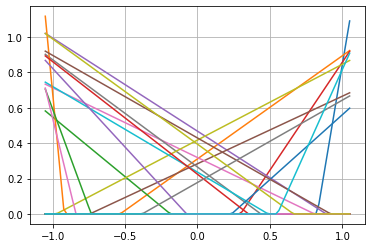

In [47]:
for c in curves:
    x,y,n = c
    plt.plot(x,y,label="%.2f x + %.2f"%(n.a, n.b))

plt.grid()
#plt.legend()

In [48]:
curves = []

for i in range(50):
    neuron = neuron_creation()
    points = [limited_neuron_evaluator(x,neuron) for x in xes]
    curves.append((xes,points, neuron))

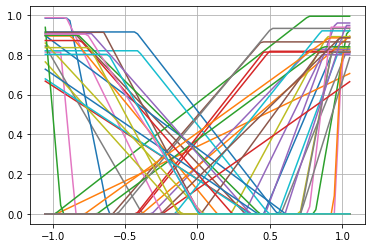

In [49]:
for c in curves:
    x,y,n = c
    plt.plot(x,y,label="%.2f x + %.2f"%(n.a, n.b))

plt.grid()
#plt.legend()

In [50]:
[i for i in range(2,20,2)]

[2, 4, 6, 8, 10, 12, 14, 16, 18]

In [51]:
Ensemble(10)

In [52]:
#Now I'll try with a few ensembles, an ensemble is a group of neurons.
#The encoded value will be ploted

ensembles = []
#make 20 different ensembles, each with 10 neurons
for i in range(10, 201, 10):
    ensembles.append(Ensemble(i))


In [53]:
%%time
#function to represent
x = np.linspace(0, 4*np.pi, 500)
#input currents to give to the neural ensemble
y = np.sin(x)
results_sat = [e.encode_saturation(y) for e in ensembles]
results_nosat = [e.encode(y) for e in ensembles]


CPU times: user 1.24 s, sys: 0 ns, total: 1.24 s
Wall time: 1.25 s


In [54]:
#to find out the needed decoder will have to get some points and then do the linear regression model
#for the output should be a linear combination of the encoded values

Xr1 = results_sat[-1]

X_train, X_test, y_train, y_test = train_test_split(Xr1, y, test_size=0.33)

In [55]:
lm = linear_model.LinearRegression()
model = lm.fit(Xr1,y)

In [56]:
xt = np.linspace(0, 8*np.pi, 1000)
yt = np.sin(xt)

In [57]:
nr = ensembles[-1].encode_saturation(yt)

In [58]:
pred = model.predict(nr)

In [59]:
model.score(X_test, y_test)

0.9999999999947664

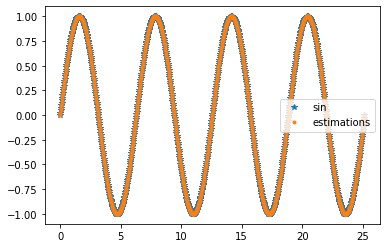

In [60]:
plt.plot(xt, yt, "*", label="sin")
plt.plot(xt, pred, ".", label="estimations")
plt.legend()

In [61]:
#it seems that the linear regression doesn work quite well, 
#I'll have to derivate it by hand and write down the equations
#and then evaluate if it is correct or not ... AGAIN!

#it seems that the error I had seen was due to some problem with the things that I was encoding! ...
# ... do more research about it until I understand it and can reproduce the results!
#The issue is that I was encoding the linear function instead of the y values of the 

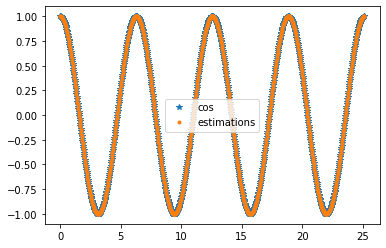

In [62]:
cxt = np.linspace(0, 8*np.pi, 1000)
cyt = np.cos(cxt)
cnr = ensembles[-1].encode_saturation(cyt)
cpred = model.predict(cnr)

plt.plot(cxt, cyt, "*", label="cos")
plt.plot(cxt, cpred, ".", label="estimations")
plt.legend()

In [63]:
#I'll graph anyways the encoded responses(each neuron point) for the input function

In [64]:
enc_10_s = np.array(results_sat[0])
enc_50_s = np.array(results_sat[4])
enc_10_ns = np.array(results_nosat[0])
enc_50_ns = np.array(results_nosat[4])

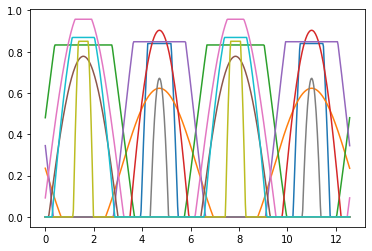

In [65]:
plt.plot(x,enc_10_s);

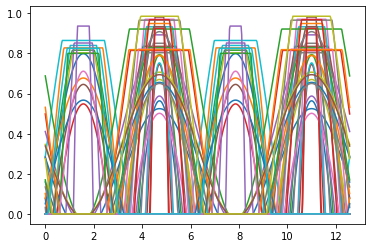

In [66]:
plt.plot(x, enc_50_s);

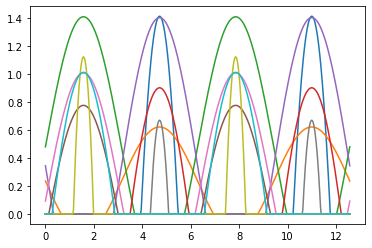

In [67]:
plt.plot(x, enc_10_ns);

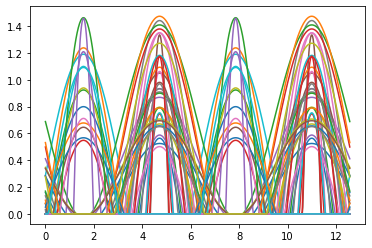

In [68]:
plt.plot(x, enc_50_ns);

In [69]:
#checking these results, we clearly see that there is a nice encoding that shows a rectified sine/cosine wave.

#The issue with saturation can be dealt with either:
# - increasing the saturation limit (anyways I do believe that saturation is needed)
# - taking out the saturation (evaluation without saturation)
# - normalizing the input to have smaller values

# The NICE thing about saturation is that it includes a really strong 
#    non-linearity that ?might? allow for interesting behaviours

#Crazy idea: Maybe saturation can be used ALSO as a kind of SIGNALING to other modules/parts



In [35]:
#Now will be a nice place to try decoding different
# functions (quadriatics, etc, oscilators, memory and some more ...

In [36]:
#Now I need to be able to instead of representing single scalars, be able to represent VECTORS -> another notebook